# Pandas Intermediate Analysis

We have covered a number of features within Pandas, such as the basics of **Series** and **DataFrame**, reading files, checking for missing data, querying/selection, aggregation, sorting/ranking.

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../Scripts")
import misc_fig
import appendage_figs

/home/gparkes/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Hierarchical Indexing

Up to this point, we've mostly focused on one-dimensional and two-dimensional data, stored in Pandas `Series` and `DataFrame` objects, respectively. Often it is useful to go beyond this and store higher dimensional data - that is, data indexed by more than one or two keys. A common pracice is to make use of *hierarchical indexing* or *multi-indexing* to incorporate multiple index levels within a single index. In this way, higher-dimensional data can be compactly represented within the familiar 1D or 2D objects.

Pandas provides for this with the `MultiIndex` object, where we consider indexing, slicing and computing statistics across multiple-indexed data. One poor way of doing this is by using Python `tuple` as keys:

In [2]:
index = [('California', 2000), ('California', 2010),
         ('New York', 2000), ('New York', 2010),
         ('Texas', 2000), ('Texas', 2010)]
populations = [33871648, 37253956,
               18976457, 19378102,
               20851820, 25145561]
pop = pd.Series(populations, index=index)
pop

(California, 2000)    33871648
(California, 2010)    37253956
(New York, 2000)      18976457
(New York, 2010)      19378102
(Texas, 2000)         20851820
(Texas, 2010)         25145561
dtype: int64

With this indexing scheme, you can index of slice based on this multiple-index:

In [3]:
pop[("California", 2010):("Texas",2000)]

(California, 2010)    37253956
(New York, 2000)      18976457
(New York, 2010)      19378102
(Texas, 2000)         20851820
dtype: int64

But if we needed to do something more complicated, (e.g select all values from 2010), we need to do expensive Pythonic munging to make this happen:

In [4]:
pop[[i for i in pop.index if i[1]==2010]]

(California, 2010)    37253956
(New York, 2010)      19378102
(Texas, 2010)         25145561
dtype: int64

### Improving on this: Pandas MultiIndex

Fortunately, Pandas has the solution. We can create a multi-index from the tuples as follows:

In [5]:
pd.MultiIndex.from_tuples(index)

MultiIndex(levels=[['California', 'New York', 'Texas'], [2000, 2010]],
           labels=[[0, 0, 1, 1, 2, 2], [0, 1, 0, 1, 0, 1]])

Notice the multiple *levels* of indexing - in this case, the state names and the years, as well as multiple *labels* for each data point which **encodes** these levels. You could think of this as using categorical labels (see the later section).

If we re-index our series with a `MultiIndex`, we see a hierarchical representation:

In [6]:
pop=pop.reindex(pd.MultiIndex.from_tuples(index))
pop

California  2000    33871648
            2010    37253956
New York    2000    18976457
            2010    19378102
Texas       2000    20851820
            2010    25145561
dtype: int64

Here the first two columns show the multiindex, and the final column shows the data. Now to access all data for `year == 2010`, we simply use the familiar Pandas slicing notation:

In [7]:
pop[:, 2010]

California    37253956
New York      19378102
Texas         25145561
dtype: int64

### MultiIndex as extra dimension

We could have instead stored the same data using a `DataFrame` with the year as a column-axis instead of a `MultiIndex`. The `unstack()` method will convert a multiply-indexed `Series` into a conventionally-indexed `DataFrame`:

In [8]:
pop_df = pop.unstack()
pop_df

,2000,2010
California,33871648,37253956
New York,18976457,19378102
Texas,20851820,25145561


Likewise this can be reversed with the `stack()` method:

In [9]:
pop_df.stack()

California  2000    33871648
            2010    37253956
New York    2000    18976457
            2010    19378102
Texas       2000    20851820
            2010    25145561
dtype: int64

Now we can take it a step further and use *hierarchical indexing* within a `DataFrame` context. Here's a below example:

In [10]:
pop_df = pd.DataFrame({"total": pop, "under18": [9267089, 9284094,
                                   4687374, 4318033,
                                   5906301, 6879014]})

In [11]:
pop_df

total  under18
California 2000  33871648  9267089
           2010  37253956  9284094
New York   2000  18976457  4687374
           2010  19378102  4318033
Texas      2000  20851820  5906301
           2010  25145561  6879014

Often it is convenient to name the levels of the `MultiIndex`. This can be done using the `names` argument to a MultiIndex constructor, else by setting the `names` attribute of the index after creation:

In [12]:
pop.index.names=["state","year"]
pop

state       year
California  2000    33871648
            2010    37253956
New York    2000    18976457
            2010    19378102
Texas       2000    20851820
            2010    25145561
dtype: int64

### Explicit MultiIndex constructors

There are a selection of methods that can generate MultiIndex constructors for you to use. The most common are `from_arrays` and `from_tuples`:

In [13]:
pd.MultiIndex.from_arrays([["a","a","b","b"],[1,2,1,2]])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [14]:
pd.MultiIndex.from_tuples([("a",1), ("a",2), ("b",1), ("b",2)])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In addition, we could construct using the Cartesian product of single indices:

In [15]:
pd.MultiIndex.from_product([["a","b"],[1, 2]])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

### MultiIndex for Index and Columns

In a `DataFrame`, the rows and columns are symmetric, and just as the rows can have multiple levels, so can the columns! 

In [16]:
def mock_health_data():
    idx=pd.MultiIndex.from_product([[2013,2014],[1,2]], names=["year","visit"])
    col=pd.MultiIndex.from_product([["Bob","Guido","Sue"],["HR","Temp"]],names=["subject","type"])
    # data
    data = np.round(np.random.randn(4, 6), 1)
    data[:,::2]*=10
    data+=37
    return data, idx, col

data, idx, col = mock_health_data()

hc_data = pd.DataFrame(data=data, index=idx, columns=col)
hc_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      54.0  37.5  44.0  37.2  24.0  35.2
     2      30.0  37.3  47.0  37.6  37.0  36.4
2014 1      38.0  36.1  31.0  37.6  39.0  38.4
     2      48.0  36.9  37.0  37.6  32.0  35.0

This essentially represents 4-dimensional data, where dimensions include subject, measurement type, the year and visit number. We can do top-level column selection by the person's name and get a full `DataFrame` containing a subject's information:

In [17]:
hc_data["Guido"]

type          HR  Temp
year visit            
2013 1      44.0  37.2
     2      47.0  37.6
2014 1      31.0  37.6
     2      37.0  37.6

In [18]:
hc_data["Guido","HR"]

year  visit
2013  1        44.0
      2        47.0
2014  1        31.0
      2        37.0
Name: (Guido, HR), dtype: float64

As with the single-index case, we can use `loc` and `iloc` as indexers for the index introduced previously:

In [19]:
hc_data.iloc[:2,:2]

subject      Bob      
type          HR  Temp
year visit            
2013 1      54.0  37.5
     2      30.0  37.3

In [20]:
hc_data.loc[:, ("Bob","HR")]

year  visit
2013  1        54.0
      2        30.0
2014  1        38.0
      2        48.0
Name: (Bob, HR), dtype: float64

### Index setting and resetting

Another way to rearrange hierarchical data is to turn the index labels into columns using the `reset_index` method. Calling this on the single Series will result in a `DataFrame`. For clarity, we can specify the name of the data for the new column(s) formed:

In [21]:
pop_flat = pop.reset_index(name="population")
pop_flat

,state,year,population
0,California,2000,33871648
1,California,2010,37253956
2,New York,2000,18976457
3,New York,2010,19378102
4,Texas,2000,20851820
5,Texas,2010,25145561


And likewise an index can be directly set using the columns already existing in the DataFrame:

In [22]:
pop_flat.set_index(["state","year"])

population
state      year            
California 2000    33871648
           2010    37253956
New York   2000    18976457
           2010    19378102
Texas      2000    20851820
           2010    25145561

### Aggregation on Multi-Indices

As previously seen, Pandas has built-in aggregation methods, such as `mean()`, `sum()` and `max()`. For hierarchically-indexes data, this can receive a `level` parameter that controls which level to aggregate over:

In [23]:
hc_data.mean(level="year")

subject   Bob       Guido         Sue      
type       HR  Temp    HR  Temp    HR  Temp
year                                       
2013     42.0  37.4  45.5  37.4  30.5  35.8
2014     43.0  36.5  34.0  37.6  35.5  36.7

Alternatively the `axis` argument specifies whether to aggregate across the rows or columns instead.

In [24]:
hc_data.mean(axis=1, level="subject")

subject       Bob  Guido   Sue
year visit                    
2013 1      45.75   40.6  29.6
     2      33.65   42.3  36.7
2014 1      37.05   34.3  38.7
     2      42.45   37.3  33.5

## Combining Datasets: Concat and Append

It is often that interesting studies of data come from different data sources. Combining these data sources can involve anything from a straightforward and simple concatenation to a more complicated database-style function such as `join` or `merge` that handle any overlaps between datasets. Pandas includes functions and methods that make this sort of data wrangling fast and easy.

In [25]:
def make_df(cols, ind):
    data = {c: [str(c) + str(i) for i in ind] for c in cols}
    return pd.DataFrame(data, ind)

make_df("ABC",range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


### Simple concatenation with `pd.concat`

Pandas has a function: `pd.concat` which has a similar syntax to `np.concatenate` but contains a number of interesting options.

```python
pd.concat(objs, axis=0, join="outer", join_axes=None, ignore_index=False, 
          keys=None, levels=None, names=None, verify_integrity=False, copy=True
```

Here we list all of the parameters associated.

In [26]:
ser1 = pd.Series(["A","B","C"],index=range(3))
ser2 = pd.Series(["D","E","F"],index=range(3,6))
pd.concat([ser1,ser2])

0    A
1    B
2    C
3    D
4    E
5    F
dtype: object

In [27]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [28]:
df1=make_df("AB",[1,2])
df2=make_df("AB",[3,4])
# misc_fig.Display("df1","df2", "pd.concat([df1, df2])")

In [29]:
display("df1","df2","pd.concat([df1, df2])")

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


By default, the concatenation happens row-wise within the DataFrame (i.e `axis=0`), We can specify the axis:

In [30]:
df3=make_df("AB",[1,2])
df4=make_df("CD",[1,2])
display("df3","df4","pd.concat([df3, df4], axis=1)")

df3
    A   B
1  A1  B1
2  A2  B2

df4
    C   D
1  C1  D1
2  C2  D2

pd.concat([df3, df4], axis=1)
    A   B   C   D
1  A1  B1  C1  D1
2  A2  B2  C2  D2

#### Duplicate indices

One important difference between `np.concatenate` and `pd.concat` is the Pandas concatenation will preserve indices, even if the result will have duplicates. Consider this example:

In [31]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make duplicate indices!
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


#### Catching the repeats as an error

If you want to verify that the indices in the result of `pd.concat` do not overlap, specify the `verify_integrity` flag. With this to `True` any concatenation will raise an exception if there are duplicate indices. 

In [32]:
try:
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:",e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the index

Sometimes the index itself does not matter, and you would prefer to ignore it. This is an option using the `ignore_index` flag.

In [33]:
display('x', 'y', 'pd.concat([x, y], ignore_index=True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex keys

Another options is to use the keys option to specify a label for the data sources; this then creates a hierarchically indexed `Series`:

In [34]:
display('x', 'y', 'pd.concat([x, y], keys=["x","y"])')

x
    A   B
0  A0  B0
1  A1  B1

y
    A   B
0  A2  B2
1  A3  B3

pd.concat([x, y], keys=["x","y"])
      A   B
x 0  A0  B0
  1  A1  B1
y 0  A2  B2
  1  A3  B3

### Concatenation with joins

In this sample we looked at `DataFrame` objects with *shared column names*. In practice, data from different sources might have different sets of column names, and `pd.concat` offers several options in this case. Consider the following concatenation:

In [35]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
#sort=false to remove a warning
display('df5', 'df6', 'pd.concat([df5, df6],sort=False)')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6],sort=False)
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

By default, entires for which no data is available is filled with `np.nan`, to change this, we can specify one of several options for `join` and `join_axes` parameters of the concat function. By default, the join is a *union* of the input columns (`join="outer"`), but we can change this to an *intersection* of the columns (`join="inner"`):

In [36]:
display('df5', 'df6', 'pd.concat([df5, df6],join="inner",sort=False)')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6],join="inner",sort=False)
    B   C
1  B1  C1
2  B2  C2
3  B3  C3
4  B4  C4

### The `append()` method

Because direct array concatenation is so common, we have an append method that can accomplish the same thing but in fewer strokes. 

In [37]:
display("df1", "df2", "df1.append(df2)")

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


Keep in mind that unlike `append()` and `extend()` from methods in Python lists, dictionaries etc, `append()` in Pandas does **NOT** modify the original object - instead it creates a new copy with the combined data. It is not very efficient either, b ecause it creates a new index and data buffer. Thus if you plan to stack multiple append operations, create a list of dataframes and pass them at once to the concat function.

## Combining Datasets: Merge and Join

One essential feature of Pandas is its' high performance, in-memory join and merge operations. Any experience with databases would have made you familiar with this type of data interaction. The main inferface for this is the `pd.merge` function, with some examples below.

### Categories of Joins 

The `pd.merge` function implements a number of types of joins:

- *One-to-one*
- *Many-to-one*
- *Many-to-many*

All three types of joins are accessed via an identical call to the `pd.merge` interface; the type of join performed depends on the form of the input data. Here we will show simple examples of the three types of merges.

#### One-to-one

Perhaps the simplest type of merge expression, very similar to the column-wise concatenation seen previously.

In [38]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2', "pd.merge(df1, df2)")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2)
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

Here the `pd.merge` function recognizes that each `DataFrame` shares the *employee* column, and automatically joins using this column as the key. The result of the merge is a new DataFrame that combines the information from the two inputs. Notice that the order of entries in each column is not necessarily maintained. Additionally keep in mind that merges in general *discard the index*, except in a few special cases of merges by index.

#### Many-to-one

Many-to-one joins are where one of the two key columns contains duplicate entries. For the many-to-one case, the resulting `DataFrame` will preserve those duplicate entries as appropriate. Consider the followign example of a *many-to-one* join:

In [39]:
df3 = pd.merge(df1, df2)
df3

,employee,group,hire_date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


In [40]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

df3
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

df4
         group supervisor
0   Accounting      Carly
1  Engineering      Guido
2           HR      Steve

pd.merge(df3, df4)
  employee        group  hire_date supervisor
0      Bob   Accounting       2008      Carly
1     Jake  Engineering       2012      Guido
2     Lisa  Engineering       2004      Guido
3      Sue           HR       2014      Steve

Here the resulting `DataFrame` has an additional column with 'supervisor' information, where the information is repeated in one or more locations as required.

#### Many-to-many

Basically as an extension to *many-to-one*, the key columns in a many-to-many relationship have duplicates in both the left and right array. Consider the following example:

In [41]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'coding', 'linux',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,group,skills
0,Accounting,math
1,Accounting,spreadsheets
2,Engineering,coding
3,Engineering,linux
4,HR,spreadsheets


It's worth remembering that in practice, the datasets are rarely as clean as the one we're working with here. In the following section we'll consider some of the options provided by `pd.merge` that enable you to tune how the join operations work.

### Specifying the Merge Key

Here we can specify which column we would actually like to merge on - using the `on` key word:

In [42]:
display('df1', 'df2', "pd.merge(df1, df2, on='employee')")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2, on='employee')
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

This option only works if both the left and right `DataFrame` both have the column `employee`.

At times however, you may wish to merge two datasets with different column names; for example we may have a dataset in which the employee name is labelled as *name* rather than *employee*. In this case we can specify those names using `left_on` and `right_on` keywords:

In [43]:
df3 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
display('df1', 'df3', 'pd.merge(df1, df3, left_on="employee", right_on="name")')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1, df3, left_on="employee", right_on="name")
  employee        group  name  salary
0      Bob   Accounting   Bob   70000
1     Jake  Engineering  Jake   80000
2     Lisa  Engineering  Lisa  120000
3      Sue           HR   Sue   90000

The result has a redundant column that we can optionally drop using `drop(#name, axis=1)`.

### The `left_index` and `right_index` keywords

Sometimes, rather than merging on a column, we want to merge on the index itself.

In [44]:
df1a = df1.set_index('employee')
df2a = df2.set_index('employee')
display('df1a', 'df2a')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


You can use the index as a key for merging as before:

In [45]:
display('df1a', 'df2a',"pd.merge(df1a, df2a, left_index=True, right_index=True)")

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


For convenience the `join()` method, also implemented by `DataFrame`, does exactly this.

If you'd like to mix indices and columns, you can combine `left_index` with `right_on` or vice versa to get the desired behaviour:

In [46]:
display('df1a', 'df3', "pd.merge(df1a, df3, left_index=True, right_on='name')")

df1a
                group
employee             
Bob        Accounting
Jake      Engineering
Lisa      Engineering
Sue                HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1a, df3, left_index=True, right_on='name')
         group  name  salary
0   Accounting   Bob   70000
1  Engineering  Jake   80000
2  Engineering  Lisa  120000
3           HR   Sue   90000

By default, `pd.merge` results in an *inner-join* or the intersection of the two sets of inputs. We can specify the type of join explicitly using the `how` keyword:

In [47]:
df6 = pd.DataFrame({'name': ['Peter', 'Paul', 'Mary'],
                    'food': ['fish', 'beans', 'bread']},
                   columns=['name', 'food'])
df7 = pd.DataFrame({'name': ['Mary', 'Joseph'],
                    'drink': ['wine', 'beer']},
                   columns=['name', 'drink'])
display('df6', 'df7', 'pd.merge(df6, df7)')

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7)
   name   food drink
0  Mary  bread  wine

In [48]:
display('df6', 'df7', 'pd.merge(df6, df7, how="outer")')

df6
    name   food
0  Peter   fish
1   Paul  beans
2   Mary  bread

df7
     name drink
0    Mary  wine
1  Joseph  beer

pd.merge(df6, df7, how="outer")
     name   food drink
0   Peter   fish   NaN
1    Paul  beans   NaN
2    Mary  bread  wine
3  Joseph    NaN  beer

#### Overlapping column names: `suffixes`

You may end up in a case where your two input `DataFrame` objects have conflicting column names. Consider this case:

In [49]:
df8 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [1, 2, 3, 4]})
df9 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'rank': [3, 1, 4, 2]})
display('df8', 'df9', 'pd.merge(df8, df9, on="name")')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name")
   name  rank_x  rank_y
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

Because there is a conflict in the `rank` column, the merge function automatically appends a suffix to each column output. These can be specified using the `suffixes` keyword:

In [50]:
display('df8', 'df9', 'pd.merge(df8, df9, on="name", suffixes=["_L","_R"])')

df8
   name  rank
0   Bob     1
1  Jake     2
2  Lisa     3
3   Sue     4

df9
   name  rank
0   Bob     3
1  Jake     1
2  Lisa     4
3   Sue     2

pd.merge(df8, df9, on="name", suffixes=["_L","_R"])
   name  rank_L  rank_R
0   Bob       1       3
1  Jake       2       1
2  Lisa       3       4
3   Sue       4       2

## Groupby: Split, Apply, Combine

Simple aggregations give you a flavour of your dataset, but often it would be nice to aggregate *conditionally* on some label or index, this is known as a *groupby* operation. The name 'groupby' comes from the popular SQL command from the database language.

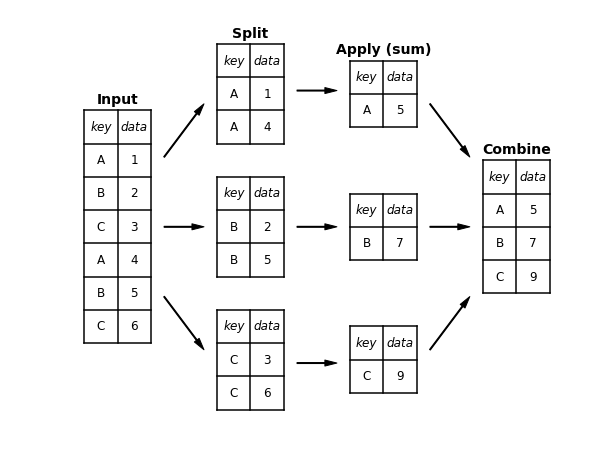

In [51]:
appendage_figs.demo_aggregate_df()

Let's go through what each step in `groupby` accomplishes:

- *Split*: Involves breaking up and grouping a `DataFrame` based on the value of the specified column/key.
- *Apply*: Computing some function, usually aggregate, transformation or filter, within individual groups.
- *Combine*: Merge the results of these operations back together into an output array.

Here's a concrete example:

In [52]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


The most basic operation can be computed with the `groupby()` method, passing the name of the desired key column(s):

In [53]:
df.groupby("key")

Pandas here returns a `DataFrameGroupBy` object, which is essentially a special view that computes nothing until an aggregation function has been given. This "lazy evaluation" approach means that common aggregates can be implemented efficiently in a way that is almost transparent to the user. To produce a result, we perform an appropriate aggregation function, for example `sum()`:

In [54]:
df.groupby("key").sum()

,data
key,
A,3
B,5
C,7


### Groupby object: Real world with cdystonia

Here we'll use a real-world example of aggregation using `groupby`:

In [55]:
cdystonia = pd.read_csv("datasets/cdystonia.csv")
cdystonia.head(3)

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24


Here we've selected a particular `Series` group from the original `DataFrame`.

In [56]:
cdystonia.groupby("patient")["twstrs"].mean().head()

patient
1    33.000000
2    47.666667
3    30.500000
4    60.000000
5    46.166667
Name: twstrs, dtype: float64

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation alone for the *apply* part of `groupby`, but there are even more options available. In particular, `groupby` objects have `aggregate()`, `filter()`, `transform()` and generic `apply()` methods that efficiently implement a variety of useful operations before combining the grouped data.

In [57]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregate

In [58]:
df.groupby("key").aggregate(["min",np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Another useful pattern is to pass a dictionary mapping column names to operations to be applied:

In [59]:
df.groupby("key").aggregate({"data1": "min", "data2": np.max})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### Filtering

A filtering operation allows you to drop data based on the group properties. For example, we might want to keep all groups where the standard deviation is larger than some critical threshold:

In [60]:
def filter_func(x):
    return x["data2"].std() > 4

display("df", "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

The `filter` function should return a Boolean value specifying whether the group passes the filtering. Here because group A does not have `std() > 4`, it is dropped.

#### Transformation

While aggregation must return a reduced version of the data, transformation must return some transformed version of the full data to recombine. In other words, transformation output is the same shape as the input. A common example would be to standardize the data by subtracting the group-wise mean:

In [61]:
display("df", "df.groupby('key').transform(lambda x: (x - x.mean()))")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').transform(lambda x: (x - x.mean()))
   data1  data2
0   -1.5    1.0
1   -1.5   -3.5
2   -1.5   -3.0
3    1.5   -1.0
4    1.5    3.5
5    1.5    3.0

### Specifying the split key

The most common case is to split the `DataFrame` on a column, however the key itself can be manually specified in a number of ways.

For example, a dictionary can map the index values to some output value, which is used in the aggregation function:

In [62]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
consonant,12,19
vowel,3,8


Including any Python function that will input the index value and output the group...:

In [63]:
display('df2', 'df2.groupby(str.lower).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,3,8
b,5,7


Furthermore, any of the preceding key choice can be combined to group on a multi-index:

In [64]:
display('df2', 'df2.groupby([str.lower, mapping]).sum()')

df2
     data1  data2
key              
A        0      5
B        1      0
C        2      3
A        3      3
B        4      7
C        5      9

df2.groupby([str.lower, mapping]).sum()
             data1  data2
a vowel          3      8
b consonant      5      7
c consonant      7     12

## Reshaping DataFrame objects: Real world example

In the context of a single DataFrame, we are often interested in re-arranging the layout of our data; particularly for machine learning where algorithms for prediction rely on strict criteria for $X$ and $y$ inputs.

To illustrate this, we will work with a dataset from "*Statistical Methods for the Analysis of Repeated Measurements by Charles S. Davis, pp. 161-163 (Springer, 2002)*", which handles some data from a controlled trial of botulinum toxin type B (BoTB) in patients with cervical dystonia.
* Response variable: (twstrs), measuring severity, pain, and disability caused from cervical dystonia.
* Measured multiple times per patient in weeks 0, 2, 4, 8, 12 and 16.

In [65]:
cdystonia = pd.read_csv("datasets/cdystonia.csv")
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


We could use the `stack()` method to rotate the dataframe, so that columns are represented as rows:

In [66]:
cdystonia.stack().head(12)

0  patient        1
   obs            1
   week           0
   site           1
   id             1
   treat      5000U
   age           65
   sex            F
   twstrs        32
1  patient        1
   obs            2
   week           2
dtype: object

We could create a **hierarchical index** with this to make the data more understandable:

In [67]:
cdystonia2 = cdystonia.set_index(['patient','obs']).drop("id",axis=1)
cdystonia2.head(8)

week  site   treat  age sex  twstrs
patient obs                                     
1       1       0     1   5000U   65   F      32
        2       2     1   5000U   65   F      30
        3       4     1   5000U   65   F      24
        4       8     1   5000U   65   F      37
        5      12     1   5000U   65   F      39
        6      16     1   5000U   65   F      36
2       1       0     1  10000U   70   F      60
        2       2     1  10000U   70   F      26

We could disregard most of the table, and unstack the response variable in columns to make it 'per patient':

In [68]:
twstrs_wide = cdystonia2.twstrs.unstack("obs")
twstrs_wide.head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


Now we could re-merge this back into the original dataset with observation and twstrs as column-data, making a wide-format:

In [69]:
cdystonia_wide = (cdystonia[['patient','site','treat','age','sex']]
     .drop_duplicates()
     .merge(twstrs_wide, right_index=True, left_on="patient", how='inner'))
cdystonia_wide.head()

,patient,site,treat,age,sex,1,2,3,4,5,6
0,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
6,2,1,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
12,3,1,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
18,4,1,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
22,5,1,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


## Pivot Tables

Now that we've explored some `groupby` and reshaping `DataFrame` objects, let's explore *pivots*. A pivot table is a similar operation seen in spreadsheets that operator on tabular data. The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summary of the data. It helps to think of pivot tables as a *multidimensional* version of `groupby` aggregation. 

We're going to be using the *Titanic* dataset again to illustrate some of their uses.

In [70]:
titanic = pd.read_excel("datasets/titanic.xlsx")
titanic.head()

,PassengerId,Age,Cabin,Port Embarked,Fare,Name,n_parents,Pclass,Sex,n_siblings,Survived,Ticket
0,1,22.0,NaN,Southampton,7.2500,"Braund, Mr. Owen Harris",0,3rd class,male,1,0,A/5 21171
1,2,38.0,C85,Cherbourg,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1st class,female,1,1,PC 17599
2,3,26.0,NaN,Southampton,7.9250,"Heikkinen, Miss. Laina",0,3rd class,female,0,1,STON/O2. 3101282
3,4,35.0,C123,Southampton,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1st class,female,1,1,113803
4,5,35.0,NaN,Southampton,8.0500,"Allen, Mr. William Henry",0,3rd class,male,0,0,373450


In [71]:
titanic.pivot_table("Survived", index="Sex", columns="Pclass")

Pclass,1st class,2nd class,3rd class
Sex,,,
female,0.979167,0.943396,0.666667
male,0.251397,0.099415,0.095335


### Multi-level pivots

Just as in the GroupBy, the grouping in pivot tables can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimension. We'll bin the age using the `pd.cut` function:

In [72]:
tit_age = pd.cut(titanic["Age"], [0, 18, 80])
titanic.pivot_table("Survived", ["Sex", tit_age], "Pclass")

Pclass           1st class  2nd class  3rd class
Sex    Age                                      
female (0, 18]    0.923077   1.000000   0.637931
       (18, 80]   0.983333   0.926829   0.638298
male   (0, 18]    0.500000   0.428571   0.152778
       (18, 80]   0.251748   0.043796   0.097473

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using `pd.qcut` to automatically compute quantiles:

In [73]:
fare = pd.qcut(titanic['Fare'], 2)
titanic.pivot_table('Survived', ['Sex', tit_age], [fare, 'Pclass'])

Fare            (-0.001, 14.454]                     (14.454, 512.329]  \
Pclass                 1st class 2nd class 3rd class         1st class   
Sex    Age                                                               
female (0, 18]               NaN  1.000000  0.800000          0.923077   
       (18, 80]              NaN  0.900000  0.687500          0.983333   
male   (0, 18]               NaN  0.000000  0.176471          0.500000   
       (18, 80]              0.0  0.059524  0.091667          0.260870   

Fare                                 
Pclass          2nd class 3rd class  
Sex    Age                           
female (0, 18]   1.000000  0.464286  
       (18, 80]  0.942308  0.533333  
male   (0, 18]   0.562500  0.131579  
       (18, 80]  0.018868  0.138889

### Additional pivot table options

The full call signature of `pivot_table` has a huge roster of options:

```python
DataFrame.pivot_table(data, values=None, index=None, columns=None, 
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```
We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones. Two of the options, `fill_value` and `dropna`, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The aggfunc keyword controls what type of aggregation is applied, which is a mean by default. As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., `sum`, `mean`, `count`, `min`, `max`, etc.) or a function that implements an aggregation (e.g., `np.sum()`, `min()`, `sum()`, etc.). Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [74]:
titanic.pivot_table(index="Sex", columns="Pclass", aggfunc={"Survived": sum, "Fare": "mean"})

Fare                        Survived                    
Pclass   1st class  2nd class  3rd class 1st class 2nd class 3rd class
Sex                                                                   
female  109.412385  23.234827  15.324250       141       100       144
male     69.888385  19.904946  12.415462        45        17        47

Note that we've omitted the `values` keyword: when using `aggfunc`, the values is the key.

## Method Chaining

You notice in one of the above examples of merging the wide-format into the whole dataset, we used function chaining to get what we wanted.

Let's say we wanted to perform a series of different operations on this data to obtain a more useful column/metric and output:

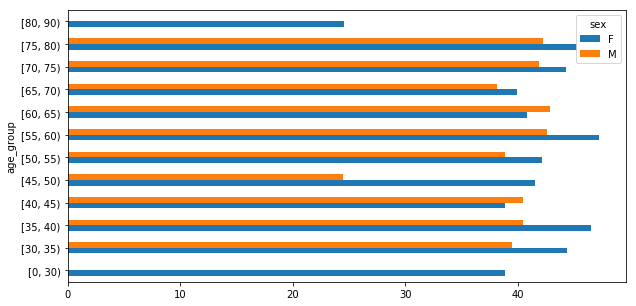

In [75]:
(cdystonia.assign(age_group=pd.cut(cdystonia.age, [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90], right=False))
    .groupby(['age_group','sex']).mean()
    .twstrs.unstack("sex")
    .fillna(0.0)
    .plot.barh(figsize=(10,5)))

## Pipes

One of the problems with method chaining is that it requires all of the functionality you need for data processing to be implemented somewhere as methods which return the actual DataFrame object in order to chain. Occasionally we want to do custom manipulations to our data, this is solved in *pipe*.

For example, we may wish to calculate the *proportion of twstrs* in the whole dataset to see differences between each patient in proportional terms across time to all of the other patients in their age group, their state of pain etc.

In [76]:
def to_proportions(df, axis=1):
    row_totals = df.sum(axis)
    return df.div(row_totals, True - axis)

(cdystonia.assign(age_group=pd.cut(cdystonia.age, [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90], right=False))
    .groupby(["week","age_group"]).mean()
    .twstrs.unstack("age_group")
    .pipe(to_proportions, axis=1))

age_group,"[0, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 90)"
week,,,,,,,,,,,,
0,0.077768,0.086100,0.090993,0.082132,0.078693,0.089248,0.087231,0.086857,0.077027,0.086563,0.090729,0.066658
2,0.109625,0.074226,0.104079,0.086025,0.081267,0.083198,0.091862,0.085873,0.080638,0.083075,0.085873,0.034258
4,0.062810,0.074888,0.102670,0.085481,0.088175,0.088900,0.096772,0.090262,0.085196,0.091497,0.094698,0.038652
8,0.080700,0.092696,0.089113,0.083385,0.082088,0.084907,0.095968,0.087442,0.082102,0.087244,0.097277,0.037079
12,0.074513,0.097672,0.085733,0.083962,0.076862,0.089694,0.091690,0.085497,0.084294,0.095155,0.090623,0.044305
16,0.078422,0.092100,0.086238,0.074634,0.075534,0.080489,0.092476,0.080743,0.080526,0.095064,0.089000,0.074774


We can now see the proportion of response variable across the age groups, per week.

## Data Transformation

We have several options for *transforming* labels and other columns into more useful features:

In [77]:
cdystonia.treat.replace({'Placebo': 0, "5000U": 1, "10000U": 2}).head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    2
7    2
8    2
9    2
Name: treat, dtype: int64

In [78]:
cdystonia.treat.astype("category").head(10)

0     5000U
1     5000U
2     5000U
3     5000U
4     5000U
5     5000U
6    10000U
7    10000U
8    10000U
9    10000U
Name: treat, dtype: category
Categories (3, object): [10000U, 5000U, Placebo]

In [79]:
pd.cut(cdystonia.age, [20,40,60,80], labels=["Young","Middle-Aged","Old"])[-25:]

606            Old
607            Old
608            Old
609            Old
610    Middle-Aged
611    Middle-Aged
612    Middle-Aged
613    Middle-Aged
614    Middle-Aged
615    Middle-Aged
616    Middle-Aged
617    Middle-Aged
618    Middle-Aged
619    Middle-Aged
620          Young
621          Young
622          Young
623          Young
624          Young
625          Young
626    Middle-Aged
627    Middle-Aged
628    Middle-Aged
629    Middle-Aged
630    Middle-Aged
Name: age, dtype: category
Categories (3, object): [Young < Middle-Aged < Old]

We can use qcut to automatically divide our data into even-sized $q$-tiles. For example $q=4$ refers to quartiles.

In [80]:
pd.qcut(cdystonia.age, 4)[-10:]

621    (25.999, 46.0]
622    (25.999, 46.0]
623    (25.999, 46.0]
624    (25.999, 46.0]
625    (25.999, 46.0]
626      (56.0, 65.0]
627      (56.0, 65.0]
628      (56.0, 65.0]
629      (56.0, 65.0]
630      (56.0, 65.0]
Name: age, dtype: category
Categories (4, interval[float64]): [(25.999, 46.0] < (46.0, 56.0] < (56.0, 65.0] < (65.0, 83.0]]

## Sparse Dataframes

*Sparse* version of Series and DataFrame are implemented in Pandas. They are not sparse in the typical sense, rather these objects are **compressed** where any data matching a specific value (`NaN`/missing) is omitted. A special `SparseIndex` object tracks where data has been *sparsified*. See this example:

In [81]:
ts = pd.Series(np.random.randn(10))
ts[2:-2] = np.nan
sts = ts.to_sparse()
sts

0    1.256553
1   -0.128329
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8    0.088458
9   -0.412876
dtype: float64
BlockIndex
Block locations: array([0, 8], dtype=int32)
Block lengths: array([2, 2], dtype=int32)

The `to_sparse()` method allows us to fill the value with something other than `NaN`:

In [82]:
ts.fillna(0.).to_sparse(fill_value=0)

0    1.256553
1   -0.128329
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.088458
9   -0.412876
dtype: float64
BlockIndex
Block locations: array([0, 8], dtype=int32)
Block lengths: array([2, 2], dtype=int32)

These Sparse objects are mostly useful for memory-efficient reasons. Suppose you had a mostly `NaN` DataFrame:

In [83]:
df = pd.DataFrame(np.random.rand(100,100))
df_sp = df.where(df < 0.02).to_sparse()
print(df_sp.density)
df_sp.head()

0.0182


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.001708,NaN,NaN,NaN,NaN,NaN


In [84]:
print("Memory usage [sparse]: %d bytes\nMemory usage [dense]: %d bytes" % (df_sp.memory_usage().sum(), df.memory_usage().sum()))

Memory usage [sparse]: 1536 bytes
Memory usage [dense]: 80080 bytes


Pandas also supports creating sparse dataframes directly from `scipy.sparse` matrices. It is worth mentioning that Pandas converts scipy matrices NOT in COOrdinate format to COO, copying data as needed. 

In [85]:
from scipy import sparse

scip_sps = sparse.coo_matrix(np.random.choice([0,1], size=(1000,1000), p=(.95, .05)))
scip_sps

<1000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 50013 stored elements in COOrdinate format>

In [86]:
sdf = pd.SparseDataFrame(scip_sps)
sdf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We **highly recommend** you check out the [cookbook](https://pandas.pydata.org/pandas-docs/stable/cookbook.html) for efficient ways of handling and processing your pandas.DataFrames.

## Tasks

You're going to be working with several different datasets including:

- **Birth rates in the US**
- **Discovered Planets**
- **fMRI data**
- **World Bank data**

They all exist within the `datasets/` directory so there is no need to download it.

### Task 1

We'll be worthing with the births dataset, which is a record from the 1960s the number of yearly/monthly births across the US.

1. Import the `births` dataset. 
2. Create a new column called `decade` that groups years together. 
3. Create a pivot with total number of births, `decade` on the x-axis and `gender` as the columns
4. (Optional) Plot the pivoted M and F values using `plt.plot`.
5. (Optional) Create a pivot but using `year` on the x-axis instead of `decade`, and re-plot

In [88]:
import matplotlib.pyplot as plt

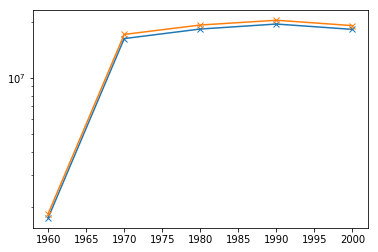

In [314]:
# 1
births = pd.read_csv("datasets/births.csv")
# 2
births["decade"] = 10*(births["year"]//10)
# 3
piv = births.pivot_table("births", index="decade", columns="gender", aggfunc="sum")
# 4
plt.semilogy(piv.index, piv["F"], 'x-')
plt.semilogy(piv.index, piv["M"], 'x-')
plt.show()

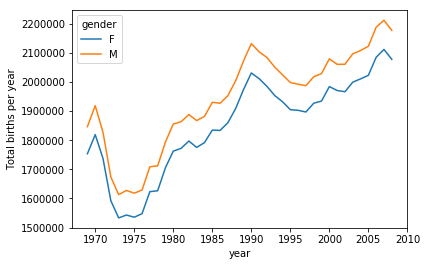

In [316]:
births.pivot_table("births", index="year", columns="gender", aggfunc="sum").plot()
plt.ylabel("Total births per year")
plt.show()

### Task 2

We're working with the planets dataset; which is a dataset recording the number of exoplanets discovered in each year, with their orbital period, mass and distance from Earth. 

1. Import the `planets` dataset.
2. Display the descriptions of all of the major aggregations using `df.describe`.
3. Calculate the median orbital period for each method.
4. Calculate the decade that each sample is in.
5. Discover and count how many discovered planets by method and by decade.
6. (Optional) Plot the scatterplot between the `mass` and the `orbital_period`, colouring by the `distance`.

In [92]:
planets = pd.read_csv("datasets/planets.csv")
planets.shape

(1035, 6)

In [93]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


In [94]:
planets.groupby("method")["orbital_period"].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

In [95]:
decade = (10*(planets["year"]//10)).astype(str) + "s"
decade.name = "decade"
planets.groupby(["method",decade])["number"].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


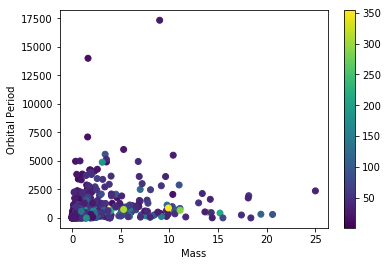

In [96]:
plt.scatter(planets.mass, planets.orbital_period, c=planets.distance)
plt.colorbar()
plt.xlabel("Mass")
plt.ylabel("Orbital Period")
plt.show()

### Task 3

We're working with an fMRI dataset; taken from www.openfmri.org, we have a number of subjects with time-series data, including the signal strength $y$, and regional descriptions. 

1. Import the fMRI dataset.
2. Create a multi-index using `timepoint` and the `event`.
3. Calculate the median `signal` across each `timepoint`. (Optionally plot)
4. Recalculate the mean `signal` across each `timepoint`, filtering out signals near $0 \pm 0.01$.
5. Convert `event` and `region` into categorical variables
6. (Optional) Using `seaborn`, produce a `catplot` with $x$ being `timepoint`, $y$ being `signal`, hue coloured by `subject`, columns being `event` and rows being `region`. Use pointplot. 

In [97]:
fmri = pd.read_csv("datasets/fmri.csv")
fmri_m = fmri.set_index(["timepoint","event"])
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


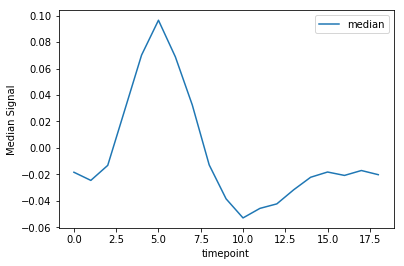

In [98]:
fmri.groupby("timepoint").signal.agg(["median"]).plot()
plt.ylabel("Median Signal")
plt.show()

In [99]:
filter_f = lambda f: (f["signal"].mean() < -.02) or (f["signal"].mean() > .02)

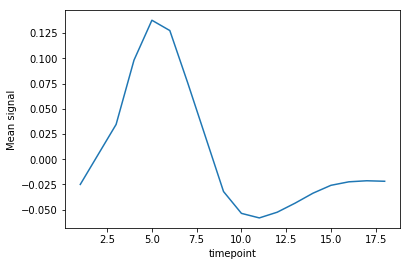

In [100]:
fmri.groupby("timepoint").filter(filter_f).groupby("timepoint").signal.mean().plot()
plt.ylabel("Mean signal")
plt.show()

In [101]:
fmri.event = fmri.event.astype("category")
fmri.region = fmri.region.astype("category")

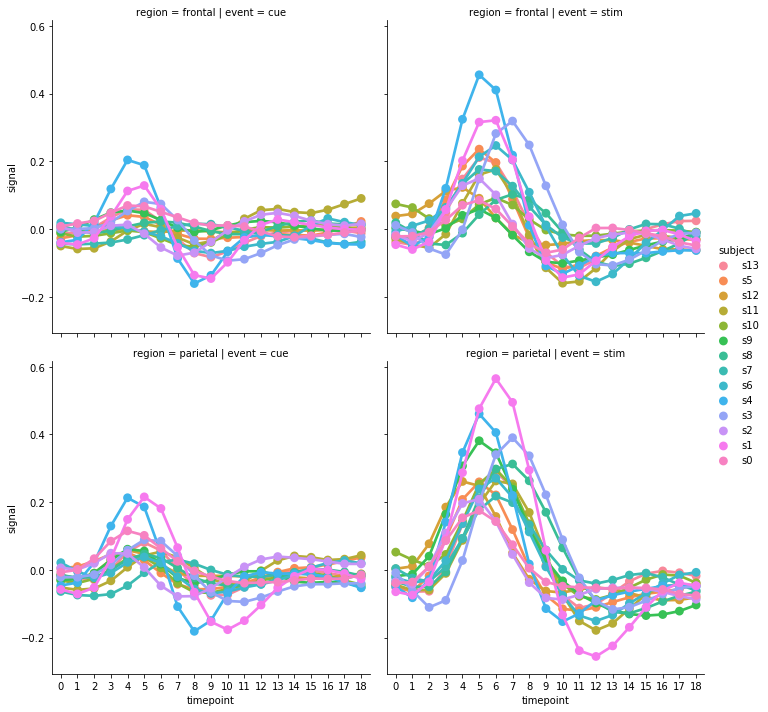

In [102]:
import seaborn as sns
sns.catplot(x="timepoint", y="signal", hue="subject", col="event", row="region", data=fmri, kind="point", alpha=.5)
plt.show()

### Task 4

We'll be working with the *World Bank data* on country population, fertility rate and life expectancy, taken from [World Bank website](www.data.worldbank.org), with thanks to [Kaggle](https://www.kaggle.com/gemartin/world-bank-data-1960-to-2016).

This data is broken into three files:

- `life_expectancy.csv`: Number of years a newborn would live if the patterns of mortality at the time of birth remain the same throughout life.
- `fertility_rate.csv`: Number of children a women would give birth during her childbearing years
- `country_population.csv`: Total number of residents regardless of legal status or citizenship (midyear estimates).

The subtasks are as follows:

1. Import all three datasets.
2. Remove countries that do not exist (such as World, or HDECs) as rows.
3. Drop any countries that have missing values.
4. Merge together the three datasets using the country code as an index. Create a MultiColumn Index for the Time-series for each data type.
5. Calculate the change in population for each year as a percentage.
6. (Optional) Plot the yearly percent change in population across time for 5 countries from the following groups: *Western Europe*, *East Asia*, *Sub-Saharan Africa* and *Middle East*.

In [103]:
# 1
life_exp = pd.read_csv("datasets/life_expectancy.csv",index_col=0)
country_pop = pd.read_csv("datasets/country_population.csv",index_col=0)
fert_rat = pd.read_csv("datasets/fertility_rate.csv", index_col=0)
print(life_exp.shape, country_pop.shape, fert_rat.shape)

(264, 60) (264, 60) (264, 60)


In [104]:
# 2
remove_words = ["World", "Europe", "Asia", "Euro", "European Union", "situation",
                "HIPC", "Latin America", "Pacific", "demographic", "income",
                "UN", "classification", "Sahara", "Middle East", "Caribbean"]
# update lists by concatenating huge OR statement and remove words that contain these segments.
fert_rat = fert_rat[~fert_rat.index.str.contains("|".join(remove_words))]
country_pop = country_pop[~country_pop.index.str.contains("|".join(remove_words))]
life_exp = life_exp[~life_exp.index.str.contains("|".join(remove_words))]

In [105]:
# 3
def compare_drop(*dfs):
    for d in dfs:
        print("Dataframe dim:{}; before {}, after {}".format(d.shape[1], d.shape[0], d.dropna().shape[0]))
    return

compare_drop(life_exp, country_pop, fert_rat)

Dataframe dim:60; before 227, after 198
Dataframe dim:60; before 227, after 221
Dataframe dim:60; before 227, after 198


In [106]:
life_exp.dropna(inplace=True)
country_pop.dropna(inplace=True)
fert_rat.dropna(inplace=True)

In [107]:
# 4
import itertools as it
dsets = [life_exp, country_pop, fert_rat]
drop_cols = ["Country Code", "Indicator Name", "Indicator Code"]
years = life_exp.drop(drop_cols, axis=1).columns.tolist()

In [108]:
nind = pd.MultiIndex.from_tuples(it.chain(zip(["life_exp"]*len(years),years),
                                   zip(["population"]*len(years),years),
                                   zip(["fert_rat"]*len(years),years)), names=["datatype","years"])

In [414]:
dfdrop = lambda df: df.drop(drop_cols, axis=1)

df_all = pd.concat([dfdrop(df) for df in dsets], axis=1, sort=False)
df_all.columns = nind
df_all.index.name = "country"

In [415]:
df_all.head(2)

datatype    life_exp                                                          \
years           1960    1961    1962    1963    1964    1965    1966    1967   
country                                                                        
Aruba         65.662  66.074  66.444  66.787  67.113  67.435  67.762  68.095   
Afghanistan   32.292  32.742  33.185  33.624  34.060  34.495  34.928  35.361   

datatype                     ...   fert_rat                              \
years          1968    1969  ...       2007   2008   2009   2010   2011   
country                      ...                                          
Aruba        68.436  68.784  ...      1.763  1.764  1.769  1.776  1.783   
Afghanistan  35.796  36.234  ...      6.460  6.254  6.038  5.816  5.595   

datatype                                        
years         2012   2013   2014   2015   2016  
country                                         
Aruba        1.791  1.796  1.800  1.801  1.800  
Afghanistan  5.380  5.174  4.981  4.802  4.635  

[2 rows x 171 columns]

In [416]:
# 5
pop_change = df_all["population"].pct_change(1,axis=1).multiply(100).drop("1960",axis=1)
pop_change.index.name = "country"

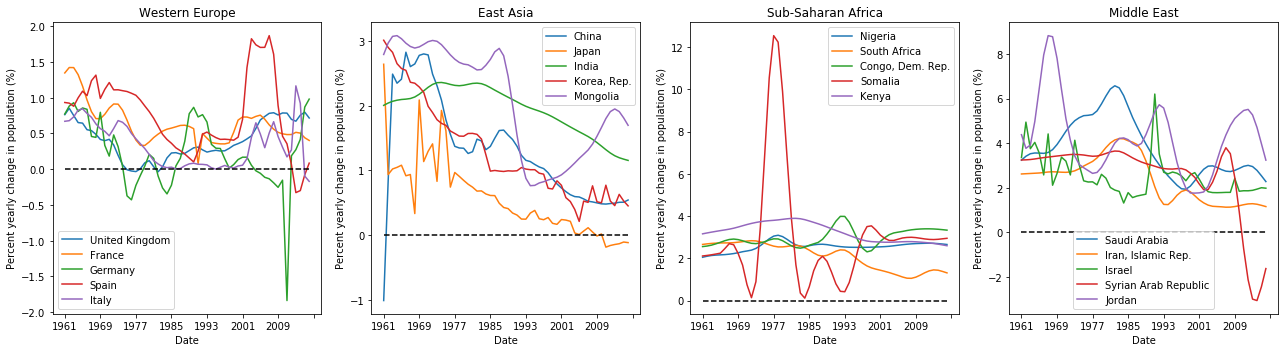

In [417]:
# 6
countries1 = ["United Kingdom", "France", "Germany", "Spain", "Italy"]
countries2 = ["China", "Japan", "India", "Korea, Rep.", "Mongolia"]
countries3 = ["Nigeria", "South Africa", "Congo, Dem. Rep.", "Somalia", "Kenya"]
countries4 = ["Saudi Arabia", "Iran, Islamic Rep.", "Israel", "Syrian Arab Republic", "Jordan"]

fig, ax = plt.subplots(ncols=4, figsize=(18,5))
for i, cs in enumerate([countries1,countries2,countries3,countries4]):
    for c in cs:
        sns.lineplot(data=pop_change.loc[c], label=c, ax=ax[i])
    
for a, t in zip(ax,["Western Europe","East Asia","Sub-Saharan Africa","Middle East"]):
    a.plot([0,55],[0,0], 'k--')
    a.legend()
    a.xaxis.set_major_locator(plt.MaxNLocator(10))
    a.set_xlabel("Date")
    a.set_ylabel("Percent yearly change in population (%)")
    a.set_title(t)

plt.tight_layout()
plt.show()

### Task 5 (Optional)

We will be continuing with the World Bank datasets provided, with some in-deep technical tasks which mostly revolve around plots. Knowledge of Matplotlib is recommended here, but you can at least do the `pandas` part of the exercises without knowing too much plotting material.

The subtasks are as follows:

1. Plot the scatterplot between **fertility rate** and **yearly percent change in population** for the *first and last* 5 years, using the life expectancy as the colour.
2. Create a column 'half-decade' that takes the average every 5 years (say 1960-64, 1965-69, etc.)
3. Calculate an *adjusted fertility rate*, whereby if two children are needed to maintain the population, $f-2$ represents the adjusted fertility rate. Negative values indicate that the population cannot be sustainably maintained by fertility alone.
4. Plot the *adjusted fertility rate* for 5 countries from the following groups: *Western Europe*, *East Asia*, *Sub-Saharan Africa* and *Middle East*.

In [472]:
# 1
a1 = pd.concat([df_all["fert_rat"].iloc[:,1:6],df_all["fert_rat"].iloc[:,-5:]], axis=1).reset_index().melt(id_vars=["country"], value_name="Fertility Rate")
a2 = pd.concat([pop_change.iloc[:,:5],pop_change.iloc[:,-5:]], axis=1).reset_index().melt(id_vars=["country"],value_name="Yearly Change in Population")
a3 = pd.concat([df_all["life_exp"].iloc[:,1:6],df_all["life_exp"].iloc[:,-5:]], axis=1).reset_index().melt(id_vars=["country"], value_name="Life Expectancy")
indexes = ["country","years"]

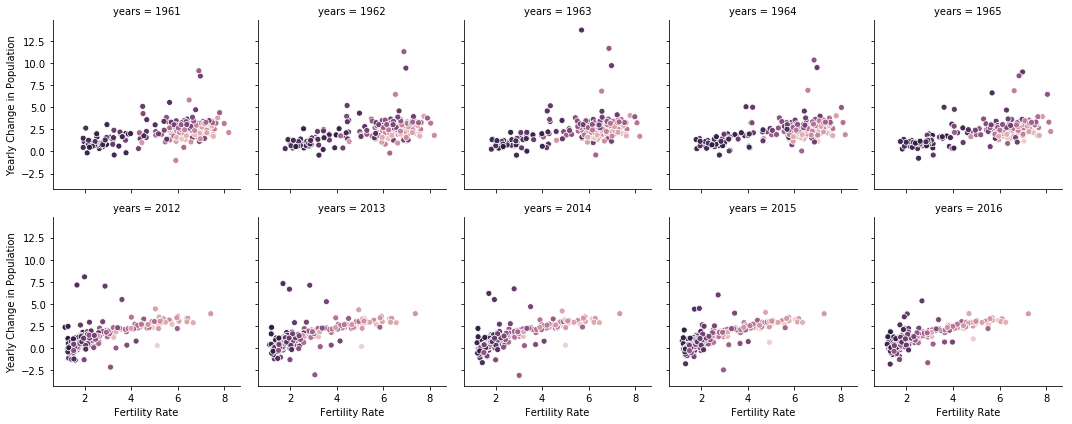

In [473]:
task5_1_long = pd.concat([a1.set_index(indexes), a2.set_index(indexes), a3.set_index(indexes)], axis=1, sort=True).reset_index()
# plot
g=sns.FacetGrid(data=task5_1_long, col="years", col_wrap=5)
g.map(sns.scatterplot, "Fertility Rate", "Yearly Change in Population", "Life Expectancy")
plt.show()

In [524]:
# 2
def chunkIt(L, n):
    """ Yield successive n-sized chunks from L.
    """
    for i in range(0, len(L), n):
        yield L[i:i+n]

In [593]:
# calculate year chunks
chunks = list(chunkIt(df_all["life_exp"].columns,5))
chunk_names = ["{}-{}".format(c[0],c[-1]) for c in chunks]

In [594]:
# generate the multi index
grouped_idx = it.chain(zip(["life_exp"]*len(chunks),chunk_names), zip(["population"]*len(chunks),chunk_names), zip(["fert_rate"]*len(chunks),chunk_names))
midx_hd = pd.MultiIndex.from_tuples(grouped_idx, names=["datatype", "year_group"])

In [599]:
# calculate raw mean measurements and concat.
half_decade = []
for g in ["life_exp", "population", "fert_rat"]:
    for name, chunk in zip(chunk_names,chunks):
        hd = df_all[g][chunk].mean(axis=1)
        hd.name = name
        half_decade.append(hd)
Half_Decade_stats = pd.concat(half_decade,axis=1)
Half_Decade_stats.columns = midx_hd
Half_Decade_stats.head()

datatype              life_exp                                          \
year_group           1960-1964 1965-1969 1970-1974 1975-1979 1980-1984   
country                                                                  
Aruba                  66.4160   68.1024   69.8398   71.4346   72.7164   
Afghanistan            33.1806   35.3628   37.5978   40.1142   43.2586   
Angola                 33.9310   35.8318   37.8788   39.7682   40.8318   
Albania                64.0272   66.2860   67.6080   69.4040   70.6536   
United Arab Emirates   54.3372   59.2034   63.1100   66.1470   68.5924   

datatype                                                                \
year_group           1985-1989 1990-1994 1995-1999 2000-2004 2005-2009   
country                                                                  
Aruba                  73.3142   73.5384   73.6754   73.9542   74.5778   
Afghanistan            47.2926   51.2642   54.0024   56.6576   59.6602   
Angola                 41.3820   42.1234   44.5004   49.3676   55.0646   
Albania                71.6912   71.8586   72.8668   74.5328   75.7030   
United Arab Emirates   70.5572   72.1150   73.4690   74.7248   75.8154   

datatype                ...    fert_rate                                \
year_group              ...    1970-1974 1975-1979 1980-1984 1985-1989   
country                 ...                                              
Aruba                   ...       2.7104    2.4514    2.3656    2.3044   
Afghanistan             ...       7.4500    7.4494    7.4510    7.4602   
Angola                  ...       7.6070    7.5858    7.4436    7.3420   
Albania                 ...       4.6418    3.9732    3.4618    3.1608   
United Arab Emirates    ...       6.4670    5.8486    5.3550    4.9106   

datatype                                                                \
year_group           1990-1994 1995-1999 2000-2004 2005-2009 2010-2014   
country                                                                  
Aruba                   2.1828    1.9810    1.8262    1.7672    1.7892   
Afghanistan             7.5108    7.6112    7.2562    6.4460    5.3892   
Angola                  7.1250    6.7968    6.5694    6.3596    6.0010   
Albania                 2.8270    2.4200    1.9848    1.6842    1.6832   
United Arab Emirates    4.0386    3.0774    2.4344    2.0164    1.8228   

datatype                        
year_group           2015-2016  
country                         
Aruba                   1.8005  
Afghanistan             4.7185  
Angola                  5.7300  
Albania                 1.7135  
United Arab Emirates    1.7565  

[5 rows x 36 columns]

In [614]:
# 3
adjusted_fert = df_all["fert_rat"].sub(2.)
adjusted_fert.head(2)

years,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,,,,,,,,,
Aruba,2.82,2.655,2.471,2.271,2.059,1.842,1.625,1.417,1.226,1.054,...,-0.237,-0.236,-0.231,-0.224,-0.217,-0.209,-0.204,-0.200,-0.199,-0.200
Afghanistan,5.45,5.450,5.450,5.450,5.450,5.450,5.450,5.450,5.450,5.450,...,4.460,4.254,4.038,3.816,3.595,3.380,3.174,2.981,2.802,2.635


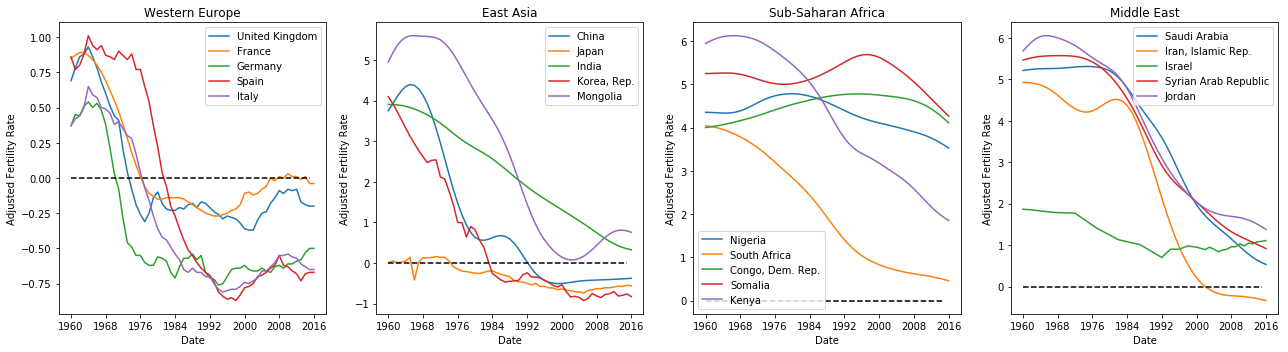

In [616]:
# 4
fig, ax = plt.subplots(ncols=4, figsize=(18,5))
for i, cs in enumerate([countries1,countries2,countries3,countries4]):
    for c in cs:
        sns.lineplot(data=adjusted_fert.loc[c], label=c, ax=ax[i])
    
for a, t in zip(ax,["Western Europe","East Asia","Sub-Saharan Africa","Middle East"]):
    a.plot([0,55],[0,0], 'k--')
    a.legend()
    a.xaxis.set_major_locator(plt.MaxNLocator(10))
    a.set_xlabel("Date")
    a.set_ylabel("Adjusted Fertility Rate")
    a.set_title(t)

plt.tight_layout()
plt.show()

### Task 6 (Optional)

What would be nice would be to predict how the populations will grow in the **future**, given the data we have. In order to do this, we should first off make some assumptions about the data:

1. Roughly 46-48% of the population are women - women that influence the **fertility rate**. We can be fairly confident that this metric remains consistent.
2. The distribution of women's age follows some sort of distribution: in this instance we recommend you choose the *Gamma distribution*. This can be obtained from the `scipy.stats` package. We can use parameters such as the population size and life expectancy per year to help determine the shape of the distribution.
3. Women between the ages of 15 to 35 are in their optimal fertility period.

Thus we can draw a sample of women from any given population given their appropriate distribution $\mathcal{G}$, and using the fertility rate, calculate within their 20-year window the probability of producing a child that year. Using this number, we can simulate those children generated and see how they compare to the actual increase in population.

Your tasks are thus as follows:

1. Write a function `new_babies`, that, given the country, year and the best $\sigma$, estimates the number of babies born that year. This can be achieved by drawing from the **Gamma distribution** with $\gamma \in [2, 4]$ and $\sigma \in [2, 12]$. Optimize for the best $\sigma$. Assume 48% of the population is female, with breeding ages between 15 and 38. Let $n$ be the total women in the population, $p$ be the estimated breeding proportion of that population, $\delta$ be the age difference between the top and bottom breeding age, and $f$ be the fertility rate, then the estimated number of new babies is:
$$
\hat{\beta}=\frac{np}{\delta}f
$$
note that $\hat{\beta} \in \mathbb{Z}$. 
2. Calculate the estimated births using a range of $\sigma \in [2, 12]$, for each year, using the life expectancy as a maximum parameter for the size of the sigma interval for the **Gamma distribution**. 

In [958]:
from scipy import stats

In [1213]:
sigma_v = np.linspace(2, 12, 100)
gamma_t = np.linspace(2, 4, df_all["life_exp"].columns.shape[0])
scaler = 10
X = np.linspace(0, 100, 100*scaler)
age_bottom, age_top = 15, 38
age_diff = age_top - age_bottom

In [1214]:
def new_babies(country, year, best_sigma):
    # calculate the number of women in the population
    n_women = df_all["population"].loc[country,year]*0.48
    # generate the pdf for the gamma distribution of women ages according to best features
    age_dist = stats.gamma.pdf(X, gamma_t[i], -1, best_sigma)
    # estimated breeding proportion is then the PDF sum scaling by the magnitude
    est_breeding_prop = np.sum(age_dist[age_bottom*scaler: age_top*scaler]) / scaler
    # return the estimated number of babies as the breeding proportion by women, scaled by fertile range, 
    # and multiply by the fertility rate.
    return int(((n_women * est_breeding_prop) / age_diff) * df_all["fert_rat"].loc[country, year])

birth_rates = []
for i, year in enumerate(years):
    sigma_r = np.asarray([stats.gamma.interval(.95, gamma_t[i], -1, s)[1] for s in sigma_v])
    # for each country in this year, calculate their best sigma.
    year_subset = df_all.dropna()["life_exp"][year]
    # best_sigmas 
    best_sig = year_subset.apply(lambda x: sigma_v[np.argmin(np.abs(sigma_r - x))])
    # for each country
    birth_rate = pd.Series([new_babies(c, year, bs) for c, bs in best_sig.items()], index=best_sig.index, name=year)
    birth_rates.append(birth_rate)
    
R = pd.concat(birth_rates, axis=1)/2

In [1215]:
R.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,,,,,,,,,
Aruba,1228.5,1225.0,1204.5,1171.0,1129.0,1083.5,1037.0,990.5,947.0,908.0,...,1002.0,1008.5,1008.5,1019.0,1022.5,1027.5,1041.5,1045.0,1056.0,1055.0
Afghanistan,167809.5,176406.5,190844.5,200465.0,210542.5,221097.5,232082.0,243494.0,255462.0,268176.0,...,1062926.5,1057856.0,1050190.5,1042383.0,1035914.5,1030542.5,1025473.0,1019826.5,1012918.5,1004421.0
Angola,112005.0,118415.0,125002.5,131664.0,138315.5,144874.5,151332.5,157815.5,164516.0,171628.0,...,827551.5,854309.5,879186.0,902118.5,925307.5,945838.0,968461.0,990859.5,1013416.0,1035930.0
Albania,48649.0,50108.5,51349.0,52168.5,52638.5,52895.0,52927.5,52930.5,53081.5,53353.0,...,27606.0,26985.5,26850.0,26709.5,26750.0,26839.5,26882.5,27103.0,26933.0,26714.0
United Arab Emirates,2790.0,3106.5,3504.0,3982.5,4464.5,4916.0,5297.0,5682.0,6149.5,6868.0,...,67530.0,74562.5,81334.5,85744.0,88943.0,89806.5,89467.5,89610.0,89042.0,88791.0


In [1217]:
pop_diff = df_all["population"].diff(axis=1).drop("1960",axis=1)
pop_diff_adj = pop_diff.drop(pop_diff.index.difference(R.index))

In [1218]:
pop_diff_adj.head()

years,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,,,,,,,,,
Aruba,1227.0,787.0,470.0,337.0,328.0,355.0,340.0,331.0,340.0,337.0,...,388.0,133.0,100.0,216.0,384.0,524.0,610.0,608.0,546.0,481.0
Afghanistan,170413.0,179104.0,188086.0,197407.0,207053.0,213917.0,220299.0,231716.0,250082.0,271695.0,...,723342.0,677239.0,710300.0,798836.0,905432.0,988359.0,1034730.0,1026332.0,978474.0,919538.0
Angola,109842.0,113037.0,114356.0,112904.0,109978.0,106471.0,105225.0,108796.0,118841.0,133749.0,...,735288.0,761733.0,790127.0,819584.0,849434.0,877585.0,902190.0,922126.0,938839.0,954158.0
Albania,51000.0,51519.0,51302.0,51514.0,50656.0,49782.0,51025.0,56674.0,59423.0,53784.0,...,-22530.0,-22703.0,-19795.0,-14498.0,-7826.0,-4794.0,-5309.0,-5988.0,-8401.0,-4602.0
United Arab Emirates,8444.0,11394.0,13094.0,12963.0,11833.0,10119.0,9802.0,12911.0,20626.0,31679.0,...,802035.0,850211.0,772115.0,604291.0,401791.0,227978.0,105810.0,64604.0,83435.0,115310.0


In [1219]:
c = "United Arab Emirates"

In [1220]:
est_pop = R.loc[c].cumsum()+df_all["population"].loc[c,"1960"]

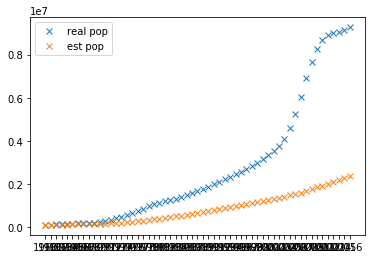

In [1221]:
plt.plot(df_all["population"].loc[c],'x',label="real pop")
# projection
plt.plot(est_pop, 'x', label="est pop")
# plt.plot(R.loc["Aruba"], 'x')
plt.legend()

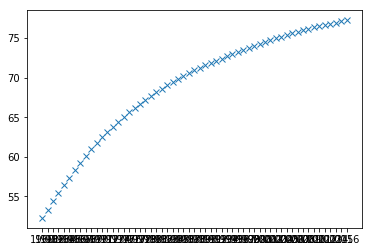

In [1222]:
plt.plot(df_all["life_exp"].loc[c], 'x')

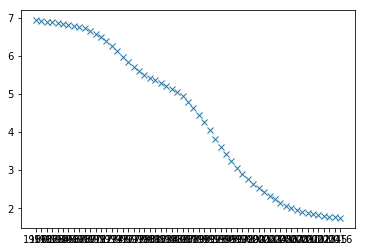

In [1223]:
plt.plot(df_all["fert_rat"].loc[c], 'x')